# Final Project

## Team Members
- Reham Abuarqoub, 9062922
- Erica Holden, 5490685
- Yu-Chen Chou (Tracy), 9006160 

## Introduction

This project analyzes space mission trends using the All Space Missions from 1957 dataset found on Kaggle at https://www.kaggle.com/datasets/agirlcoding/all-space-missions-from-1957

The All Space Missions from 1957 dataset, sourced from Kaggle, contains detailed records of space missions spanning more than six decades. It includes information such as the mission name, launch date, rocket name, launch location, organization, mission status, and rocket status. Analyzing this dataset provides valuable insights into the history and progression of space exploration. The central goal of this project is to examine trends in space missions, identify patterns through clustering, and understand how factors such as country, rocket usage, and success rates have evolved over time.

The analysis begins with data cleaning, an essential step in preparing the dataset for accurate and reliable results. This involves handling missing values, correcting inconsistencies in naming conventions, and ensuring proper formatting of date and categorical fields. Standardizing country and organization names is particularly important to avoid skewing results when grouping missions by these attributes. Similarly, converting dates into usable formats allows for the extraction of temporal features such as decade, year, or month, which are crucial for historical trend analysis.

Through visualizations such as line charts and bar graphs, we can detect shifts in space activity — for example, the initial dominance of the United States and the Soviet Union during the Space Race era, the emergence of new players such as China and private companies in later decades, and the overall growth in the number of missions over time.

Beyond descriptive analysis, the project employs clustering techniques to uncover groups of missions with similar characteristics. Clustering can be based on variables such as mission decade, launch country, rocket cost (if available), success rate, and mission purpose. By identifying clusters, we can explore what differentiates them — for example, certain clusters may represent high-cost, high-success-rate missions from developed space programs, while others might group low-cost or experimental missions with mixed success outcomes. This approach helps uncover relationships and patterns that are not immediately obvious from raw statistics alone.

The use case for this analysis is broad and impactful. For historical research, the findings provide a clear timeline of technological advancements, geopolitical shifts, and the growth of the commercial space sector. For policy makers and industry stakeholders, understanding past trends in rocket use and mission success can inform future investments and collaborations. For data science and machine learning applications, the dataset offers a real-world example of how clustering and EDA can be applied to categorical, temporal, and numerical data.

By combining careful data preparation with statistical analysis and clustering, this project delivers insights that go beyond simple counts and percentages. It highlights the evolution of space exploration from its Cold War origins to the present era of international cooperation and commercial innovation, offering a data-driven perspective on one of humanity’s most ambitious endeavors.

## Tasks

* Clustering: Cluster launches by decade.
* Classification: Predict whether a mission will be successful or fail based on features like launch vehicle, country, payload, etc.
* Regression: Predict payload mass or cost based on mission details.
* Probabilistic Reasoning: Estimate the probability of mission success given country and vehicle type.

In [179]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Cleaning the Data

In [180]:
# Load dataset
df = pd.read_csv('./data/Space_Corrected.csv')

# Define a class for cleaning the space mission dataset
class DataCleaner:
    def __init__(self, df):
        self.df = df

    def clean(self):
        df = self.df.copy()
        df.columns = df.columns.str.strip()

        # Remove unnecessary fields
        df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, errors='ignore')
        
        # Remove missing values
        df = df.dropna(subset=['Status Mission', 'Rocket'])

        # Convert “Rocket” column to numeric
        df['Rocket'] = pd.to_numeric(df['Rocket'], errors='coerce')

        # Convert 'Datum' column to datetime format
        df['Datum'] = pd.to_datetime(df['Datum'], errors='coerce')

        # Label unification and dualization
        df['Status Mission'] = df['Status Mission'].str.strip().str.capitalize()
        df['Mission_Success_Binary'] = df['Status Mission'].map(lambda x: 1 if x == 'Success' else 0)
        
        # Label Encoding
        categorical_cols = ['Company Name', 'Location', 'Detail']
        for c in categorical_cols:
            df[c] = df[c].astype('category')

        # Handling outliers
        df = df[df['Rocket'] >= 0]
        df = df[df['Datum'].dt.year >= 1957]

        # Remove duplicate data
        df = df.drop_duplicates()

        return df

# Create an instance of DataCleaner and clean the DataFrame 
df_clean = DataCleaner(df).clean()
df_clean.head()

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,Mission_Success_Binary
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,1
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,1
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,1
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,1
5,CASC,"LC-9, Taiyuan Satellite Launch Center, China",2020-07-25 03:13:00+00:00,"Long March 4B | Ziyuan-3 03, Apocalypse-10 & N...",StatusActive,64.68,Success,1


## Data Analysis - Normality Testing - Shapiro-Wilk Test

This is important for choosing appropriate statistical methods.

In [181]:
df_clean['Rocket_Family'] = df['Detail'].str.extract(r'([A-Za-z]+(?:\s\d+)?)') # Use original df Detail string
df_clean['Rocket_Use_Count'] = df_clean.groupby('Rocket_Family')['Rocket_Family'].transform('count')
stat, p = shapiro(df_clean['Rocket_Use_Count'])

print('Shapiro-Wilk Test statistic:', stat)
print('p-value:', p)
if p < 0.05:
    print('Data is not normally distributed.')
else:
    print('Data is likely normally distributed.')

Shapiro-Wilk Test statistic: 0.8978107343085591
p-value: 1.5448492171364048e-24
Data is not normally distributed.


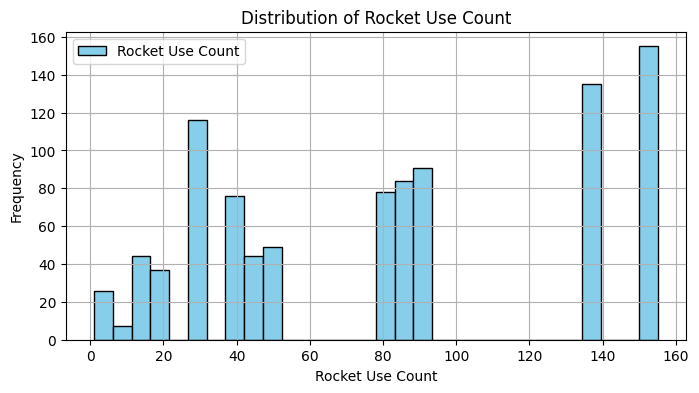

<Figure size 800x400 with 0 Axes>

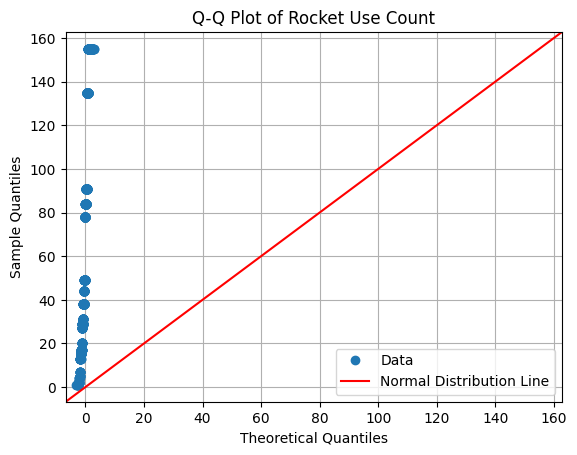

In [182]:
# Display the distribution of Rocket Use Count
plt.figure(figsize=(8,4))
plt.hist(df_clean['Rocket_Use_Count'], bins=30, edgecolor='black', color='skyblue', label='Rocket Use Count')
plt.title('Distribution of Rocket Use Count')
plt.xlabel('Rocket Use Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Display the Q-Q plot
plt.figure(figsize=(8,4))
fig = sm.qqplot(df_clean['Rocket_Use_Count'], line='45')
ax = fig.axes[0]
ax.set_title('Q-Q Plot of Rocket Use Count')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')
lines = ax.get_lines()
lines[0].set_label('Data')
lines[1].set_label('Normal Distribution Line')
ax.grid(True)
ax.legend()
plt.show()

## Clustering

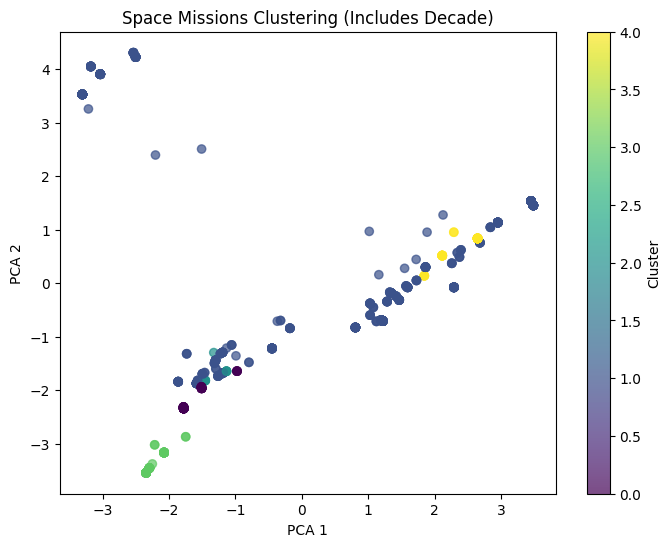

In [183]:
# Extract the decade from the date year
df_clean['Year'] = pd.to_datetime(df_clean['Datum'], errors='coerce').dt.year
df_clean['Decade'] = (df_clean['Year'] // 10) * 10
df_clean['Country'] = df_clean['Location'].str.split(',').str[-1].str.strip()

# Select features for clustering
features = df_clean[['Decade', 'Country', 'Rocket_Family', 'Company Name', 'Rocket_Use_Count']]
features = features.astype(str).fillna('0')
features = features.fillna(0)

# One-hot encode categorical features
features_encoded = pd.get_dummies(features)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_encoded)

# Cluster
kmeans = KMeans(n_clusters=5, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters by decade
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=df_clean['Cluster'], cmap='viridis', alpha=0.7)
plt.title('Space Missions Clustering (Includes Decade)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [184]:
# Print table of cluster counts by decade
decade_cluster_counts = df_clean.groupby(['Decade', 'Cluster']).size().unstack(fill_value=0)
print(decade_cluster_counts)

Cluster   0    1   2   3   4
Decade                      
1960      0   25   0   0   0
1980      0   42   0   0   0
1990      5   98   0   0  28
2000     16  154   0  26  12
2010     45  353  15  67   4
2020      0   49   1   2   0


## Data Analysis - Chi Square Test & Heatmap

This shows that India dominates Cluster 0, there are many countries but mostly USA in Cluster 1, Kazakhstan in Cluster 2, France in Cluster 3, and mostly USA in Cluster 4.

Chi-square statistic: 2302.576078195731
p-value: 0.0
There is a significant association between Country and Cluster.

 Cluster        0    1   2   3   4
Country                          
China          0  156   0   0   0
France         0    0   0  95   0
Gran Canaria   0    0   0   0   2
India         66    0   0   0   0
Japan          0   40   0   0   0
Kazakhstan     0   26  16   0   0
New Zealand    0   13   0   0   0
Russia         0   54   0   0   0
USA            0  431   0   0  42
Yellow Sea     0    1   0   0   0


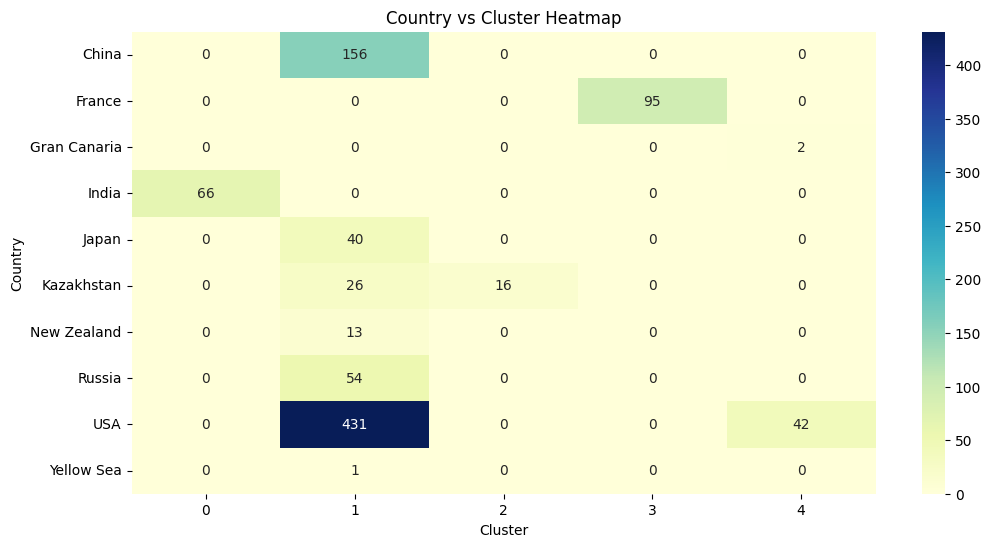

In [185]:
# Create a contingency table
contingency_table = pd.crosstab(df_clean['Country'], df_clean['Cluster'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print('Chi-square statistic:', chi2)
print('p-value:', p)
if p < 0.05:
    print('There is a significant association between Country and Cluster.')
else:
    print('No significant association between Country and Cluster.')

print("\n",contingency_table)

plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Country vs Cluster Heatmap")
plt.xlabel("Cluster")
plt.ylabel("Country")
plt.show()

## Data Analysis - ANOVA Test & Mean Counts

This shows that there is a significant difference in Rocket_Use_Count means between clusters. Cluster 1 has the highest Rocket_Use_Count.

In [189]:
# Group Rocket_Use_Count by Cluster
groups = [group['Rocket_Use_Count'].values for name, group in df_clean.groupby('Cluster')]

# Perform one-way ANOVA
stat, p = f_oneway(*groups)

print('ANOVA F-statistic:', stat)
print('p-value:', p)
if p < 0.05:
    print('There is a significant difference in Rocket_Use_Count means between clusters.')
else:
    print('No significant difference in Rocket_Use_Count means between clusters.')

mean_counts = df_clean.groupby('Cluster')['Rocket_Use_Count'].mean()
mean_counts_df = mean_counts.reset_index()
print("\n", mean_counts_df)

ANOVA F-statistic: 35.12962493429942
p-value: 2.3018604934390037e-27
There is a significant difference in Rocket_Use_Count means between clusters.

    Cluster  Rocket_Use_Count
0        0         40.757576
1        1         89.504854
2        2         16.000000
3        3         66.452632
4        4         44.000000


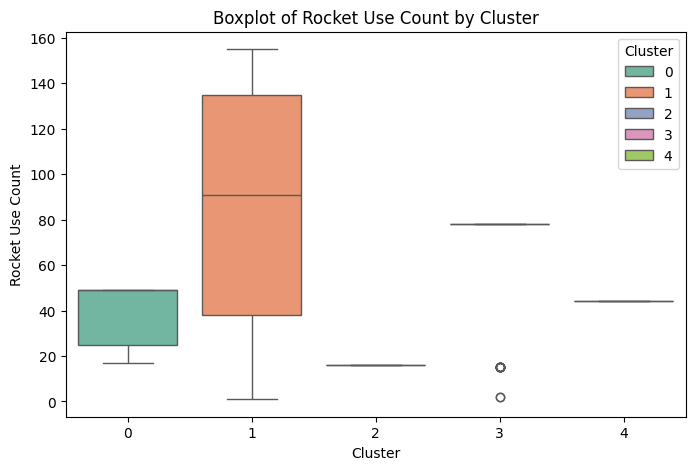

In [190]:
# Display the boxplot of Rocket Use Count by Cluster
plt.figure(figsize=(8,5))
sns.boxplot(x='Cluster', y='Rocket_Use_Count', data=df_clean, palette='Set2', hue='Cluster')
plt.title('Boxplot of Rocket Use Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Rocket Use Count')
plt.show()

## Summary of Clusters

| Cluster | Main Contributing Countries       | Likely Characteristics                                    | Notes |
|---------|-----------------------------------|------------------------------------------------------------|-------|
| 0       | India                             | Specialized missions distinct from other clusters          | Possibly smaller payload or regional focus |
| 1       | USA, China, Russia, Japan, NZ     | Main workhorse missions (large volume, multiple nations)   | Likely satellite launches or common mission profiles |
| 2       | Kazakhstan                        | Niche mission type with limited contributors               | Possibly specific to regional or technical constraints |
| 3       | France                            | Highly specialized missions                                | Could relate to ESA or French-led space programs |
| 4       | USA, Gran Canaria                 | Small niche group                                          | May involve unique launch sites or rare mission types |


## Probabilistic Reasoning


 Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.90      0.11        10
           1       0.97      0.16      0.27       179

    accuracy                           0.20       189
   macro avg       0.51      0.53      0.19       189
weighted avg       0.92      0.20      0.26       189



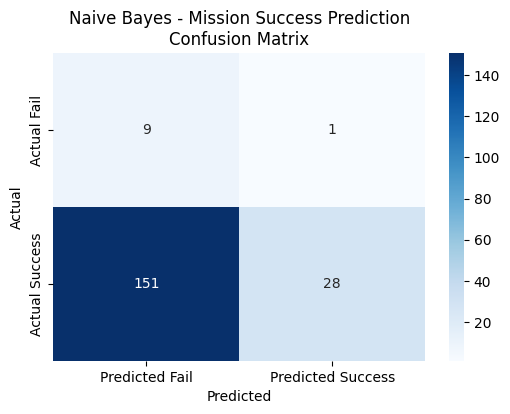


Mean Predicted Success Probability by Cluster:
Cluster
0    2.142857e-01
1    1.517241e-01
2    1.000000e+00
3    5.555556e-02
4    1.375952e-85
Name: Predicted_Prob, dtype: float64


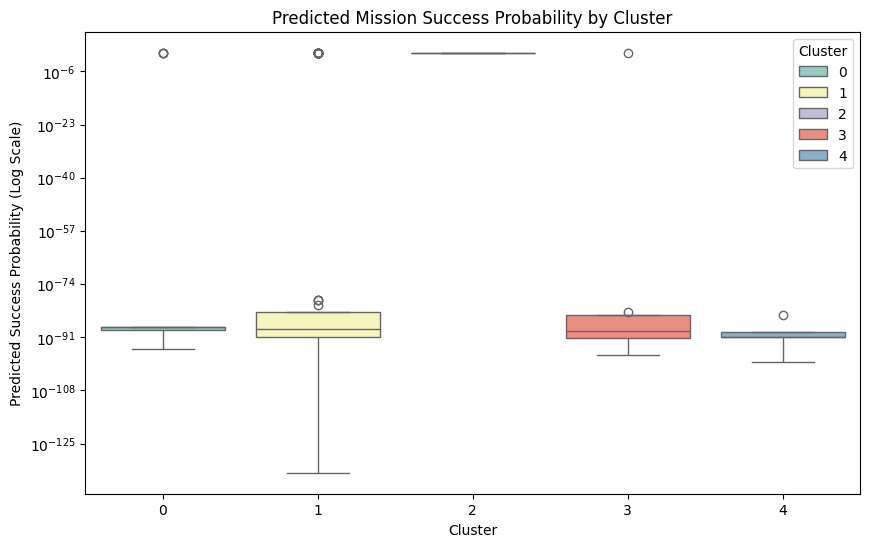


Actual Success Rate by Cluster:
Cluster
0    0.857143
1    0.951724
2    1.000000
3    1.000000
4    0.888889
Name: Actual, dtype: float64


In [191]:
# Create a composite stratify column
df_clean['stratify_col'] = df_clean['Mission_Success_Binary'].astype(str) + "_" + df_clean['Cluster'].astype(str)
stratify_counts = df_clean['stratify_col'].value_counts() # Count the number of occurrences of each stratify_col combination
single_sample_strata = stratify_counts[stratify_counts == 1].index # Find combinations that occur only once
df_clean_filtered = df_clean[~df_clean['stratify_col'].isin(single_sample_strata)].copy() # Filter out rows from df_clean that belong to these single-sample categories

# Reset the index of features_encoded and df_clean and then synchronize them.
features_encoded = features_encoded.reset_index(drop=True)
df_clean_filtered = df_clean_filtered.reset_index(drop=True)

# Use the index of the filtered df_clean_filtered to select the corresponding row in features_encoded
X_filtered = features_encoded.loc[df_clean_filtered.index]
y_filtered = df_clean_filtered['Mission_Success_Binary']
stratify_col_filtered = df_clean_filtered['stratify_col']

# Features and labels
X = X_filtered # Feature set after one-hot encoding
y = y_filtered # Target variable

# Split the data (keeping the y category distribution consistent)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_col_filtered
)
cluster_train = df_clean_filtered.loc[X_train.index, 'Cluster']
cluster_test = df_clean_filtered.loc[X_test.index, 'Cluster']

#print("Train Cluster distribution:\n", cluster_train.value_counts())
#print("Test Cluster distribution:\n", cluster_test.value_counts())

# Build a Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Prediction and prediction probability
y_pred = nb_model.predict(X_test)
y_prob = nb_model.predict_proba(X_test)[:, 1] # Mission success probability

# Evaluation report
print("\n Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Fail', 'Predicted Success'],
            yticklabels=['Actual Fail', 'Actual Success'])
plt.title('Naive Bayes - Mission Success Prediction\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Import the predicted probability and cluster into a DataFrame and analyze the probability distribution of different clusters
results_df = pd.DataFrame({
    # Reset the index of all Series to ensure their indices match
    'Cluster': cluster_test.reset_index(drop=True),
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred,
    'Predicted_Prob': y_prob
})

# Compare the average success probability of each cluster
cluster_prob_mean = results_df.groupby('Cluster')['Predicted_Prob'].mean()
print("\nMean Predicted Success Probability by Cluster:")
print(cluster_prob_mean)

# Box plot of success probability distribution for each cluster
plt.figure(figsize=(10,6))
sns.boxplot(x='Cluster', y='Predicted_Prob', data=results_df, palette='Set3', hue='Cluster')
plt.title('Predicted Mission Success Probability by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Predicted Success Probability (Log Scale)')
plt.yscale('log')
plt.show()

# Actual success rate for each cluster
cluster_actual_success_rate = results_df.groupby('Cluster')['Actual'].mean()
print("\nActual Success Rate by Cluster:")
print(cluster_actual_success_rate)